In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download NLTK assets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Unzip the dataset file and store it in a folder called dataset.
!unzip "/content/drive/MyDrive/A Comprehensive Dataset for Automated Cyberbullying Detection.zip" -d "/content/dataset/"

Archive:  /content/drive/MyDrive/A Comprehensive Dataset for Automated Cyberbullying Detection.zip
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/1. users_data.csv  
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/6. CB_Labels.csv  
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/2. peerness_values.csv  
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/3. Aggressive_All.csv  
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/5. Communication_Data_Among_Users.csv  
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/4. Non_Aggressive_All.csv  
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/Code.zip  


In [4]:
import pandas as pd

# Load necessary CSV files from the extracted directory
cb_labels_df = pd.read_csv("/content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/6. CB_Labels.csv")
users_df = pd.read_csv("/content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/1. users_data.csv")
communication_df = pd.read_csv("/content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/5. Communication_Data_Among_Users.csv")

In [5]:
import pandas as pd

# Merge user demographic info into CB_Labels
merged_df = cb_labels_df.merge(users_df, how='left', left_on='User1 ID', right_on='UserID', suffixes=('', '_User1'))
merged_df = merged_df.merge(users_df, how='left', left_on='User2 ID', right_on='UserID', suffixes=('', '_User2'))
merged_df.drop(columns=['UserID', 'UserID_User2'], inplace=True)

# Count number of messages and aggressive messages per (User1, User2)
communication_df['Message'] = communication_df['Message'].astype(str)
message_counts = communication_df.groupby(['User1 ID', 'User2 ID']).agg(
    num_messages=('Message', 'count'),
    num_aggressive=('Label', 'sum')
).reset_index()

# Merge back with demographic-enriched dataset
merged_df = merged_df.merge(message_counts, on=['User1 ID', 'User2 ID'], how='left')
merged_df[['num_messages', 'num_aggressive']] = merged_df[['num_messages', 'num_aggressive']].fillna(0)

In [6]:
merged_df.head()

,User1 ID,User2 ID,Total_messages,Aggressive_Count,Intent_to_Harm,Peerness,CB_Label,Age,Gender,School Name,Grade,Age_User2,Gender_User2,School Name_User2,Grade_User2,num_messages,num_aggressive
0,1,2,36,23,0.769444,0.500000,1,11,Others,School10,5,15,Male,School5,9,36,23
1,1,3,16,9,0.481250,0.766667,1,11,Others,School10,5,11,Male,School13,5,16,9
2,1,4,17,8,0.447794,0.366667,0,11,Others,School10,5,17,Male,School14,11,17,8
3,1,5,24,15,0.612500,0.366667,0,11,Others,School10,5,17,Male,School6,11,24,15
4,1,6,15,7,0.420833,0.433333,1,11,Others,School10,5,16,Male,School12,10,15,7


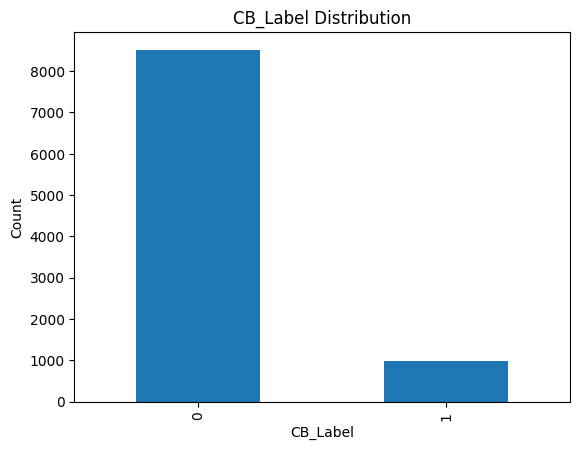

In [22]:
import matplotlib.pyplot as plt
merged_df['CB_Label'].value_counts().plot(kind='bar')
plt.title('CB_Label Distribution')
plt.xlabel('CB_Label')
plt.ylabel('Count')
plt.show()

# Pre-processing

In [7]:
# NLP Preprocessing Functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [8]:
# Concatenate messages per dyad and preprocess
communication_df['Clean_Message'] = communication_df['Message'].apply(preprocess)
dyad_messages = communication_df.groupby(['User1 ID', 'User2 ID'])['Clean_Message'].apply(lambda msgs: ' '.join(msgs)).reset_index()

# Merge with CB_Labels to attach final labels
lstm_input_df = pd.merge(dyad_messages, cb_labels_df[['User1 ID', 'User2 ID', 'CB_Label']], on=['User1 ID', 'User2 ID'], how='inner')


In [9]:
lstm_input_df.head()

,User1 ID,User2 ID,Clean_Message,CB_Label
0,1,2,bye bye dear bajaj got better work watching ur...,1
1,1,3,bother fuckface suck cock dear gwernol u usele...,1
2,1,4,ron paul ron paul hasnt withdrawn thought id l...,0
3,1,5,vandalism disagree limey frustrating today cra...,0
4,1,6,rt fanwalker sexistbut theory female unable te...,1


# Duplicates and Missing Values

In [10]:
# How many reviews do we have?
print('There are', lstm_input_df.shape[0], 'data in this dataset')

# Do we have duplicates?
print('Number of Duplicates:', len(lstm_input_df[lstm_input_df.duplicated()]))

# Do we have missing values?
missing_values = lstm_input_df.isnull().sum()
print('Number of Missing Values by column:\n',missing_values)

print('Number of Missing Values:', lstm_input_df.isnull().sum().sum())

There are 9511 data in this dataset
Number of Duplicates: 0
Number of Missing Values by column:
 User1 ID         0
User2 ID         0
Clean_Message    0
CB_Label         0
dtype: int64
Number of Missing Values: 0


# Text Preparation for LSTM

In [11]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(lstm_input_df['Clean_Message'])

sequences = tokenizer.texts_to_sequences(lstm_input_df['Clean_Message'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)

# Data Splitting

In [12]:
# Split data into training and testing sets
X = padded_sequences
y = lstm_input_df['CB_Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (7608, 100)
Testing data shape: (1903, 100)
Training labels shape: (7608,)
Testing labels shape: (1903,)


# Model Definition

In [14]:
# define a model

model = Sequential([
    Embedding(5000, 64, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Model Training
history = model.fit(X_train, y_train, epochs=10, validation_split=0.3, batch_size=32)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8880 - loss: 0.3847 - val_accuracy: 0.8922 - val_loss: 0.3102
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9034 - loss: 0.2617 - val_accuracy: 0.8914 - val_loss: 0.3476
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9339 - loss: 0.1665 - val_accuracy: 0.8598 - val_loss: 0.4549
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9795 - loss: 0.0739 - val_accuracy: 0.8638 - val_loss: 0.5100
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9918 - loss: 0.0378 - val_accuracy: 0.8414 - val_loss: 0.6219
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9953 - loss: 0.0315 - val_accuracy: 0.8708 - val_loss: 0.6980
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9941 - loss: 0.0291 - val_accuracy: 0.8476 - val_loss: 0.7138
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9961 - loss: 0.0175 - val_acc

Test Accuracy: 83.87%
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1685
           1       0.19      0.12      0.15       218

    accuracy                           0.84      1903
   macro avg       0.54      0.53      0.53      1903
weighted avg       0.81      0.84      0.82      1903



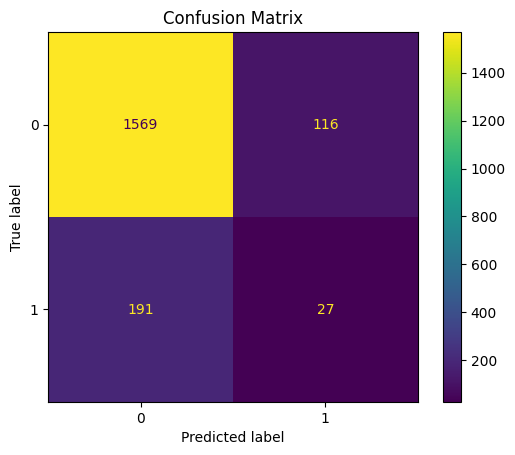

In [21]:

import matplotlib.pyplot as plt
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predictions and Evaluation Metrics
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

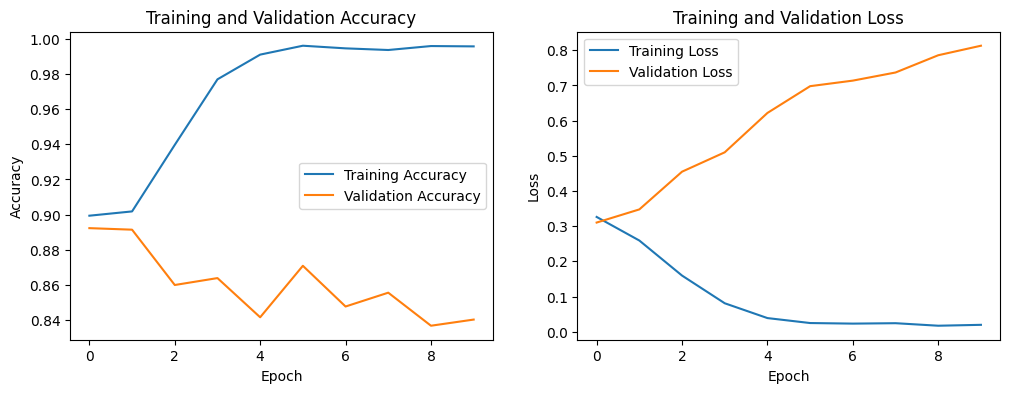

In [17]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()